In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.decomposition import PCA
from pympler.asizeof import asizeof

In [18]:
def pca_compression(data, threshold):
    # extracts rgb channels
    channels = tuple(data[:, :, i] for i in range(data.shape[2]))
    # selects n values resulting in accumulated_variance_ratio_ >= threshold for each channel
    channels_n_components = tuple(np.argwhere(np.cumsum(
        PCA().fit(ch).explained_variance_ratio_) >= threshold)[0, 0] + 1 for ch in channels)
    # creates PCA model for each channel
    pcas = tuple(PCA(channels_n_components[i]).fit(ch)
                 for i, ch in enumerate(channels))
    # returns compressed data and decryption key
    return tuple(pca.transform(channels[i]) for i, pca in enumerate(pcas)), pcas

In [19]:
def main(image, threshold=.9):
    fig = plt.figure()
    fig.suptitle('original image')
    fig.add_subplot().set_title(
        f'bytes occupied: {asizeof(image)}, dim={image.shape[:2]}')
    plt.imshow(image)
    plt.show()
    # normalizing rgb values
    image /= 255
    # compress image and send it
    compressed_image, pcas = pca_compression(image, threshold)
    components = [pca.get_params()['n_components'] for pca in pcas]
    # decompress image
    decompressed_image = np.empty(shape=image.shape)
    decompressed_image[:, :, 0], decompressed_image[:, :, 1], decompressed_image[:, :, 2] = np.array(
        [pca.inverse_transform(compressed_image[i]) for i, pca in enumerate(pcas)])
    fig = plt.figure()
    fig.suptitle('decompressed image')
    fig.add_subplot().set_title(
        f'bytes occupied: {decompressed_image.nbytes}, transferred bytes: {asizeof(compressed_image)}, n_components={components}')
    # transform image from normalized to original
    plt.imshow(decompressed_image * 255)
    plt.show()

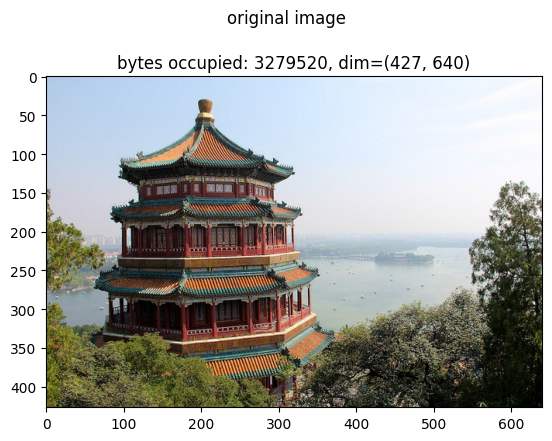

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


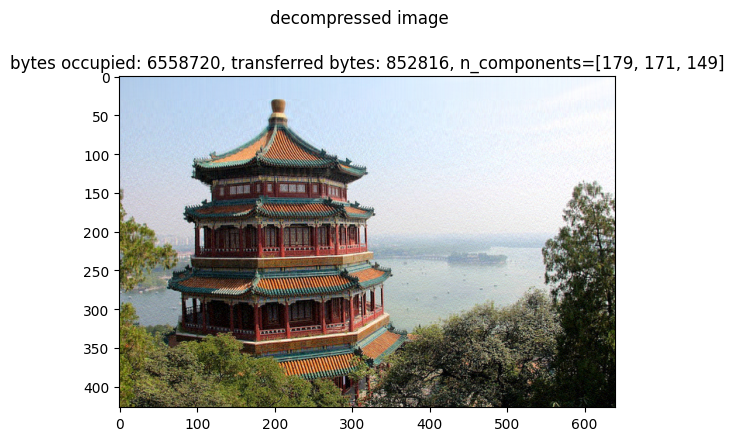

In [20]:
image = imread('china-original.png')
main(image, .99)

### It is observed that we can reduce image's size by ~75% through capturing 99% of image's variance without major quality loss in this example.